In [7]:
import sys
import os

# Ruta al proyecto raíz donde está la carpeta 'scripts'
project_root = os.path.abspath('../../../')  # o usa la ruta absoluta si prefieres
sys.path.append(project_root)

In [8]:
import pandas as pd 
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from scripts.remove_outliers import remove_outliers

In [9]:
df_data_general = pd.read_csv('../../../data/data_general.csv')

df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]

df_data_general = df_data_general[df_data_general['WIN_TOTAL'] > 0]
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']
df_data_general = df_data_general[df_data_general['NET_SPEND'] < 10000 ]

In [10]:
columns = ['AVG_BET', 'Edad',
        'INITIAL_AMOUNT', 'GAMES_PLAYED_TOTAL',
        'GAMES_WON_TOTAL', 'Rango_Edad_le','TIME_ON_DEVICE_MIN']

df = df_data_general[columns]

In [11]:
X = df.drop(['Edad', 'TIME_ON_DEVICE_MIN'], axis=1)

In [12]:
std_scaler = StandardScaler()

df_scaler = std_scaler.fit_transform(X)

In [13]:
wdcc = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaler)    
    wdcc.append(kmeans.inertia_)

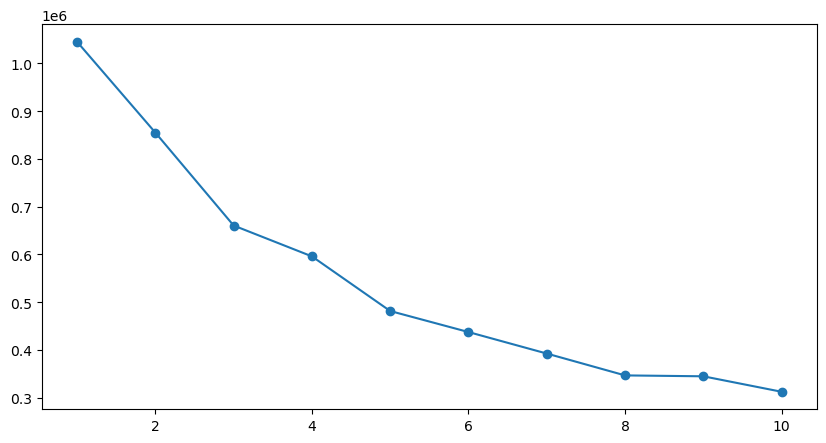

In [14]:
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wdcc, marker='o')

In [15]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_scaler)

KMeans(n_clusters=4)

In [16]:
clusters = kmeans.predict(df_scaler)

In [17]:
df['Cluster'] = clusters

/var/folders/ld/2yb_9mvs5t90r3x4r3v3btbc0000gn/T/ipykernel_1509/1851257265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = clusters


In [18]:
df.groupby('Cluster').mean()

AVG_BET       Edad  INITIAL_AMOUNT  GAMES_PLAYED_TOTAL  \
Cluster                                                             
0        10.544513  55.363691      617.136319          163.630740   
1         3.878684  42.977254      206.672647          143.468492   
2         3.589633  59.050770      305.793743         1376.045152   
3         3.350499  65.777933      206.668061          157.784964   

         GAMES_WON_TOTAL  Rango_Edad_le  TIME_ON_DEVICE_MIN  
Cluster                                                      
0              50.667282       3.534755           12.814927  
1              42.183001       2.288877           11.139615  
2             432.706721       3.865481           93.105400  
3              46.304634       4.515854           12.631308

<AxesSubplot: xlabel='Edad', ylabel='TIME_ON_DEVICE_MIN'>

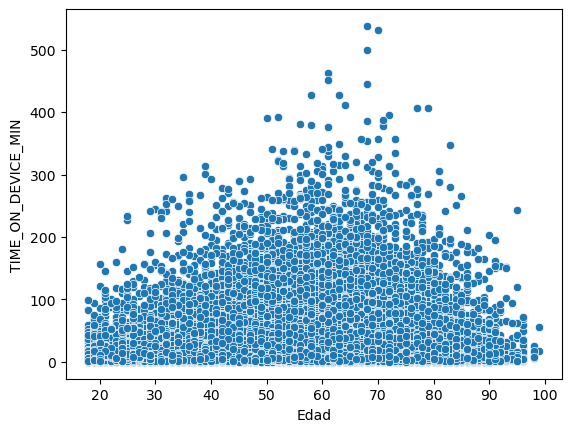

In [19]:
sns.scatterplot(df, y='TIME_ON_DEVICE_MIN', x='Edad')

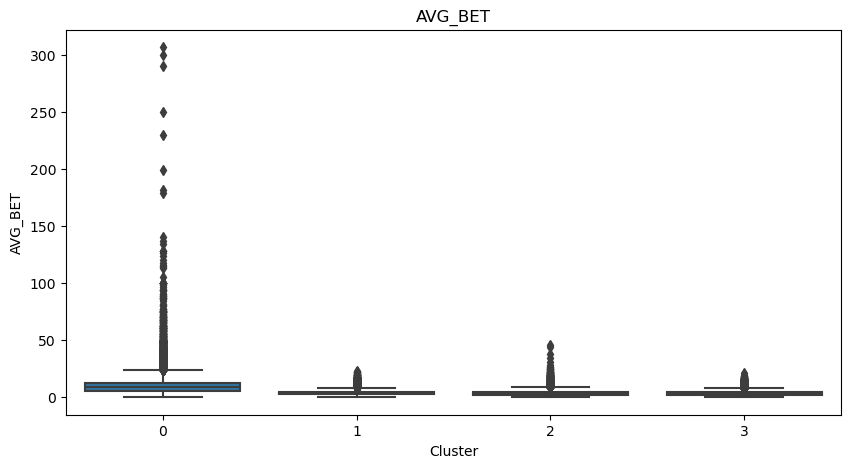

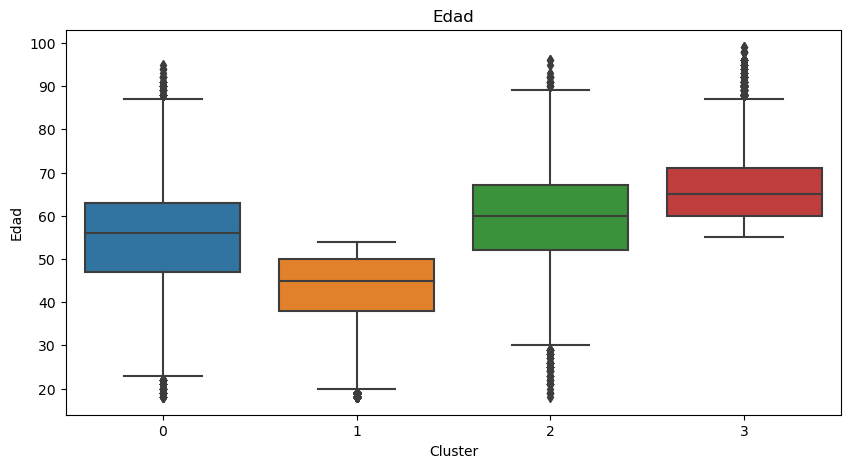

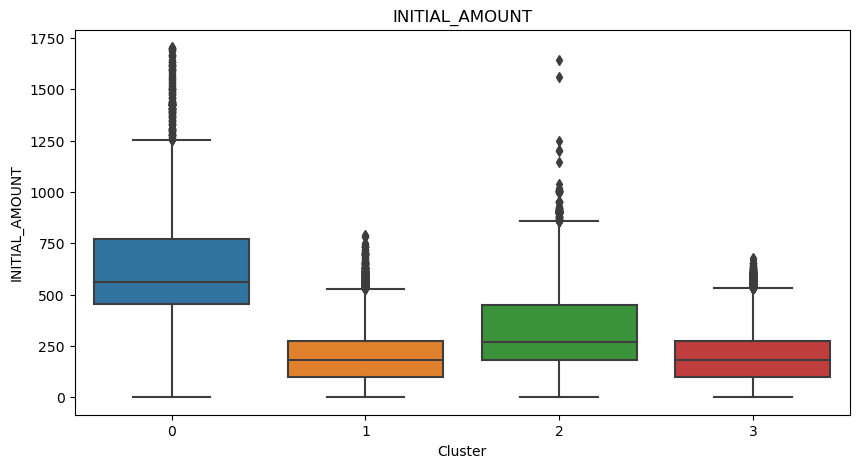

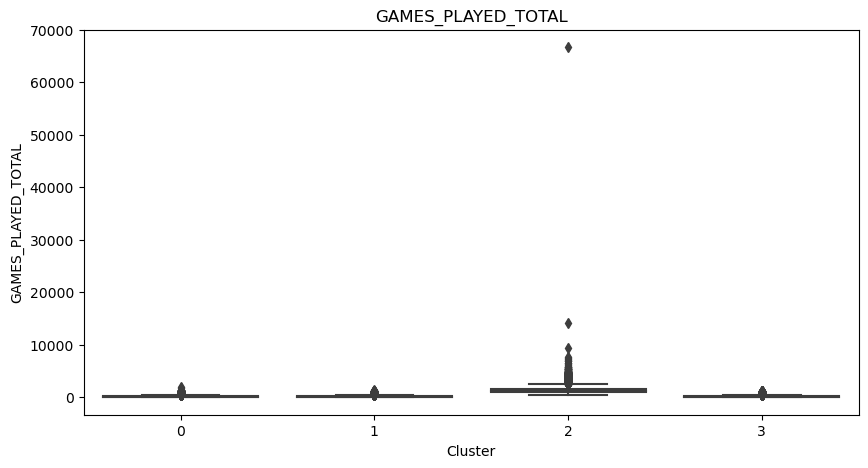

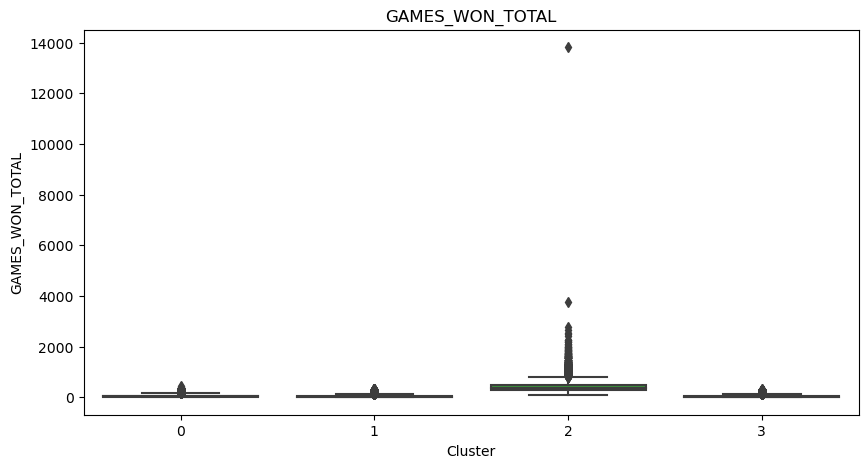

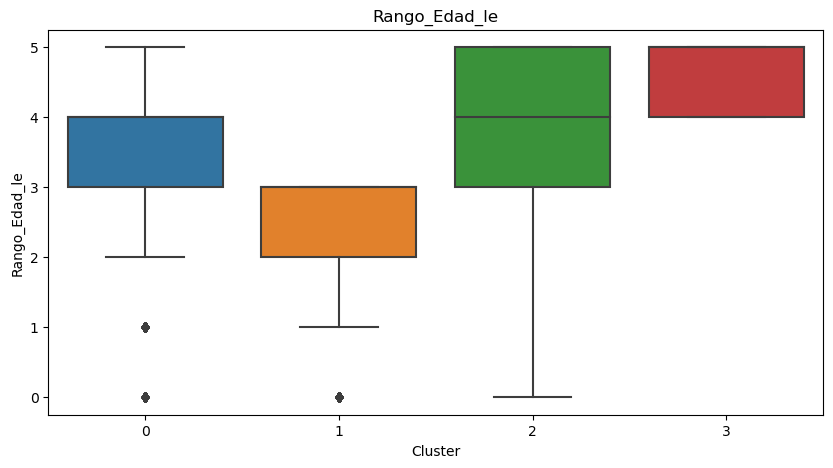

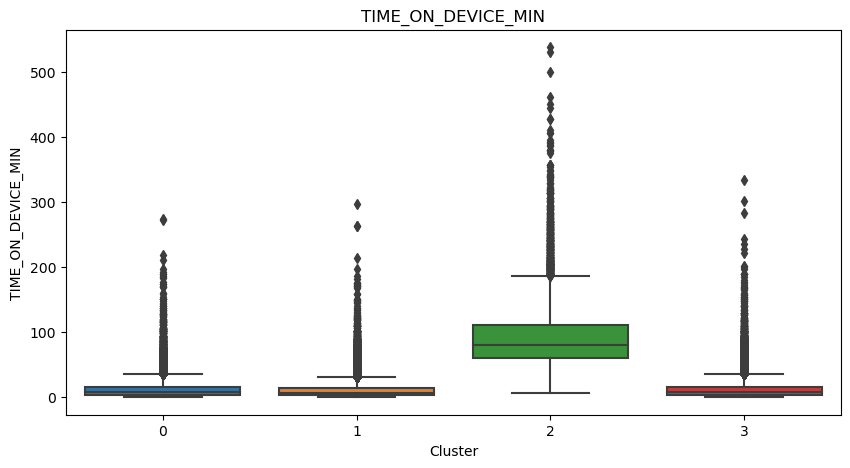

In [20]:
for column in columns:
    plt.figure(figsize=(10,5))
    plt.title(f"{column}")
    sns.boxplot(df,y=column, x='Cluster')

In [30]:
df_cluster3 = df.loc[df['Cluster'] == 1]

df_cluster_3 = remove_outliers(df_cluster3, 'GAMES_PLAYED_TOTAL')
df_cluster_3 = remove_outliers(df_cluster3, 'GAMES_WON_TOTAL')

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

## Time On Device Min

### Standard Scaler + Poly

AVG_BET vs Time On Device Min. R2 0.010958869632540336
Edad vs Time On Device Min. R2 0.0010833619047125875
INITIAL_AMOUNT vs Time On Device Min. R2 0.011485325685855474
GAMES_PLAYED_TOTAL vs Time On Device Min. R2 0.6560263866563516
GAMES_WON_TOTAL vs Time On Device Min. R2 0.6269699869339732
Rango_Edad_le vs Time On Device Min. R2 0.0009154520242609099
TIME_ON_DEVICE_MIN vs Time On Device Min. R2 1.0
Cluster vs Time On Device Min. R2 0.0


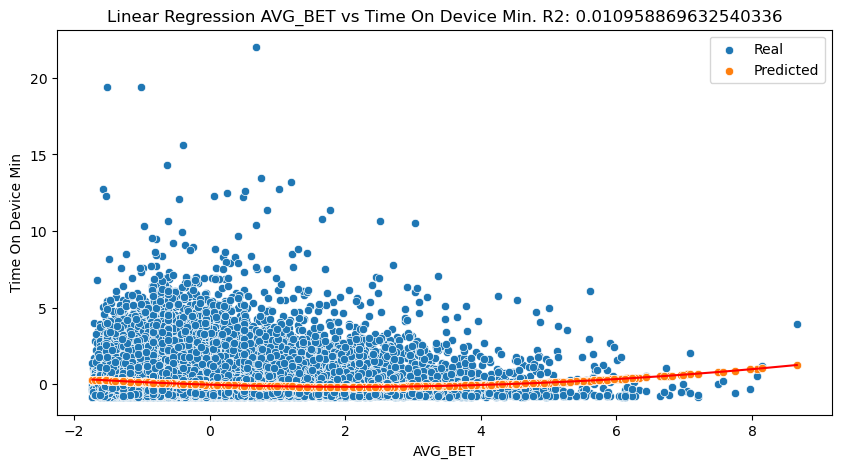

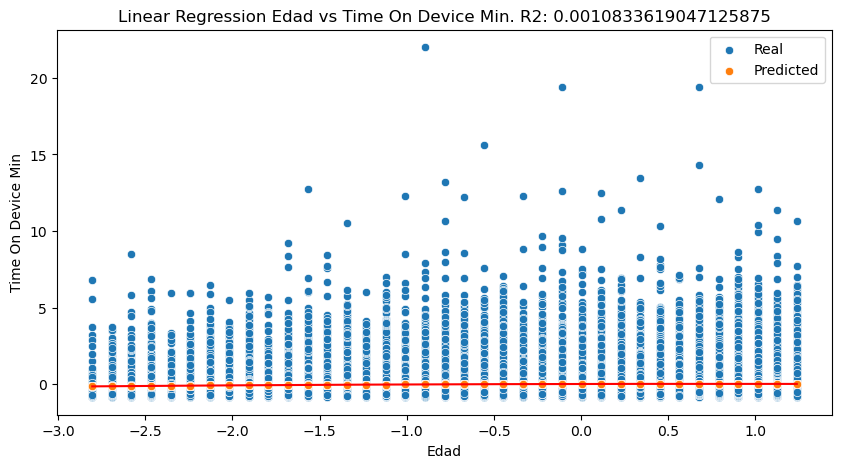

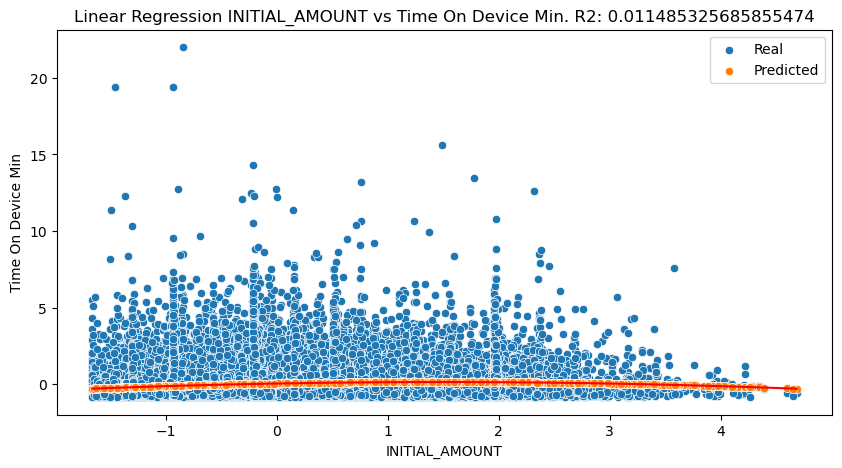

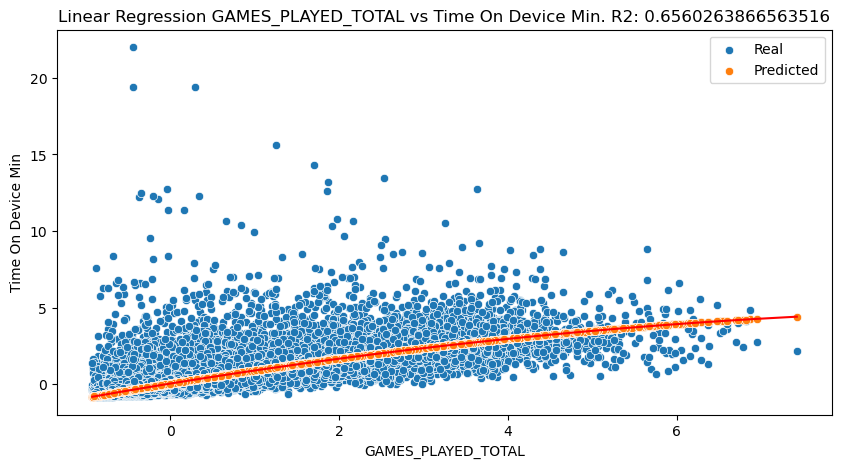

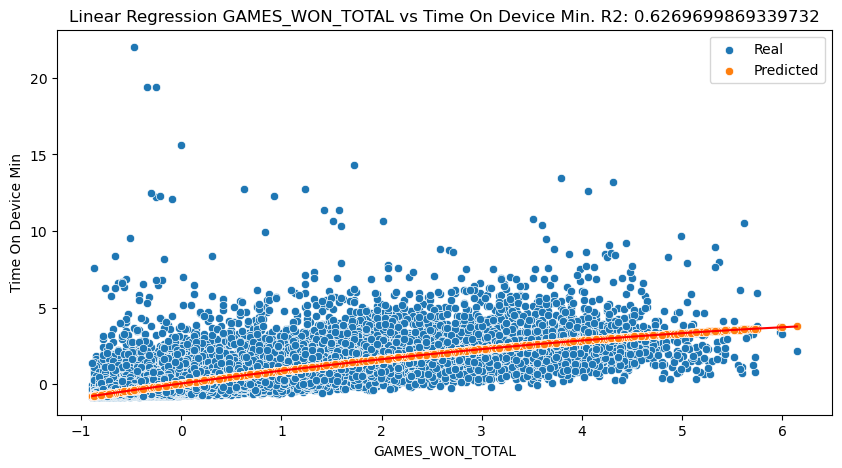

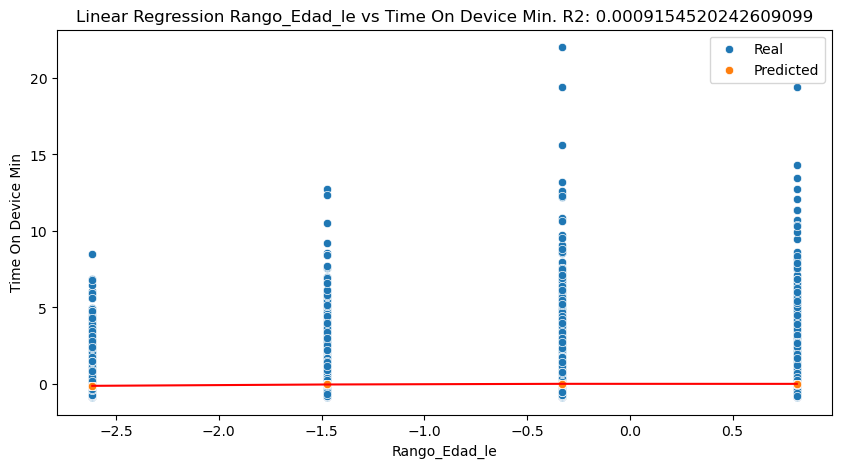

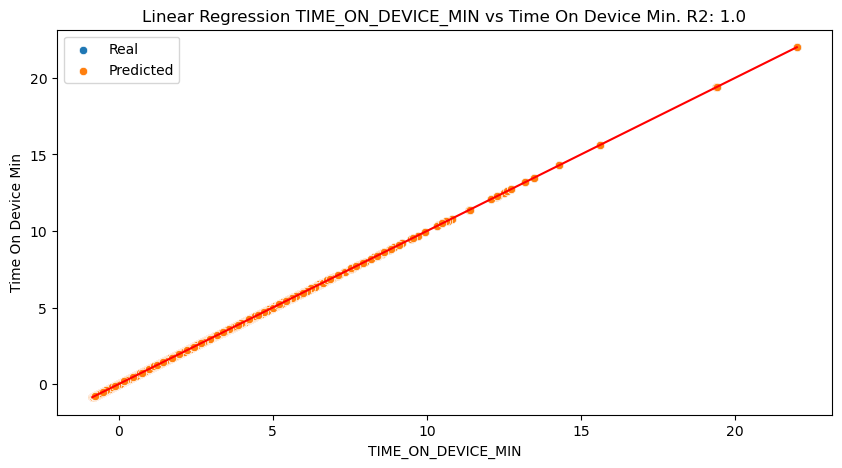

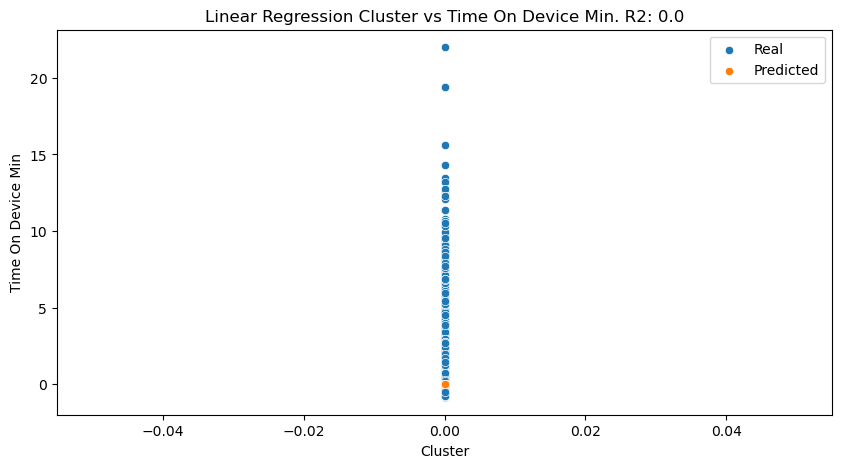

In [32]:
std_scaler_time = StandardScaler()
y = df_cluster3[['TIME_ON_DEVICE_MIN']]
y_scaled = std_scaler_time.fit_transform(y)
for column in df_cluster3.columns:
    std_scaler = StandardScaler()
    X = df_cluster3[[column]]
    X_scaled = std_scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_scaled)
    lr = LinearRegression()

    lr.fit(X_poly, y_scaled)
    y_hat = lr.predict(X_poly)

    r2_value = r2_score(y_scaled, y_hat)
    plt.figure(figsize=(10,5))
    # Para graficar, usamos el X original (una sola variable)
    sns.scatterplot(x=X_scaled.ravel(), y=y_scaled.ravel(), label='Real')
    sns.scatterplot(x=X_scaled.ravel(), y=y_hat.ravel(), label='Predicted')

    # Ordenamos X para graficar una curva suave
    sorted_idx = np.argsort(X_scaled.ravel())
    plt.plot(X_scaled.ravel()[sorted_idx], y_hat.ravel()[sorted_idx], color="red")



    plt.title(f"Linear Regression {column} vs Time On Device Min. R2: {r2_value}")
    plt.xlabel(column)
    plt.ylabel("Time On Device Min")
    print(f"{column} vs Time On Device Min. R2 {r2_value}")

### Standard Scaler

AVG_BET vs Time On Device Min. R2 0.006916783205669019
Edad vs Time On Device Min. R2 0.0008711927299742683
INITIAL_AMOUNT vs Time On Device Min. R2 0.008751194947409946
GAMES_PLAYED_TOTAL vs Time On Device Min. R2 0.6513857144874111
GAMES_WON_TOTAL vs Time On Device Min. R2 0.6220806277101654
Rango_Edad_le vs Time On Device Min. R2 0.0005878179149468865
TIME_ON_DEVICE_MIN vs Time On Device Min. R2 1.0
Cluster vs Time On Device Min. R2 0.0


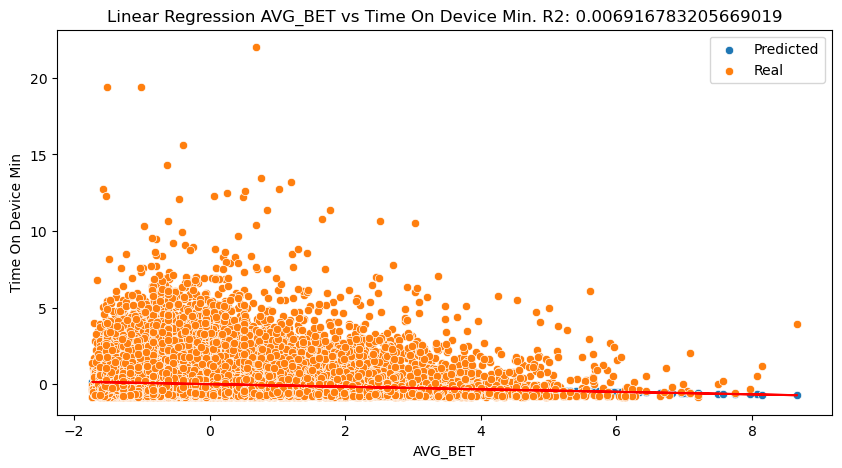

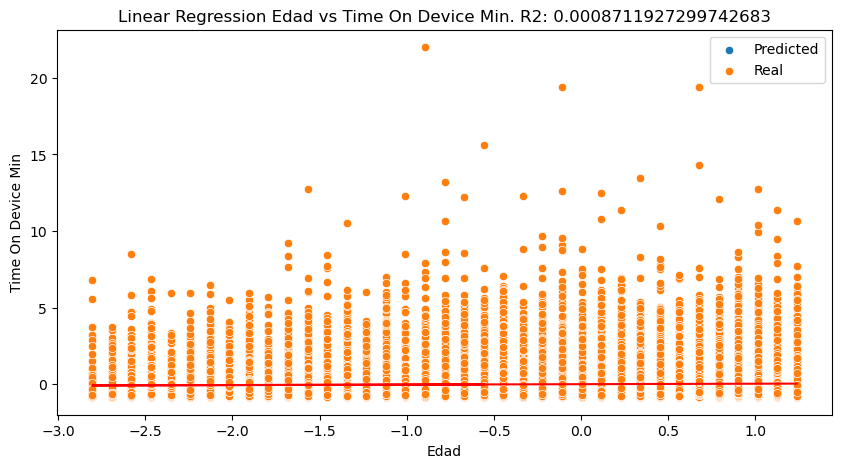

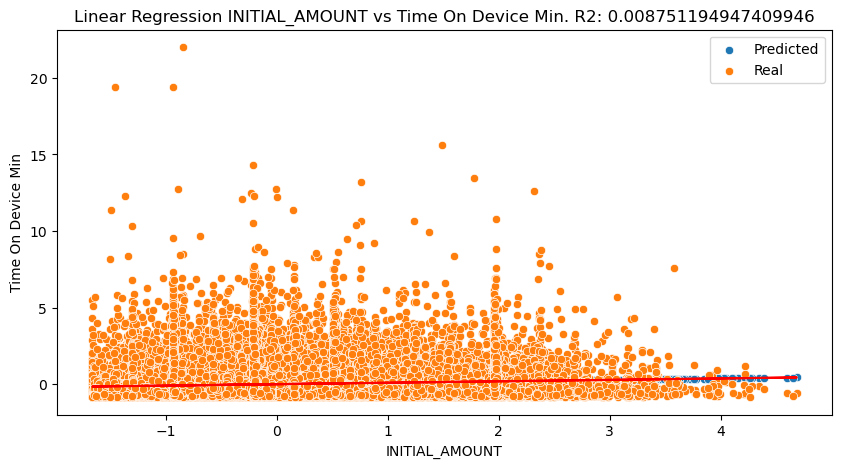

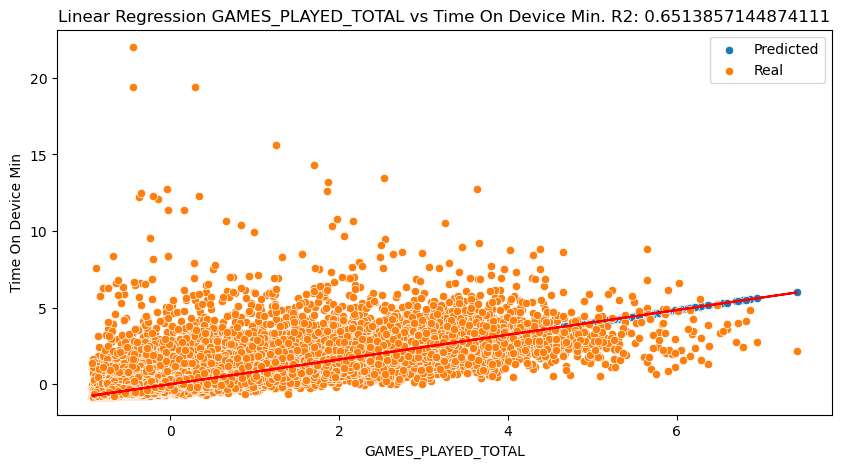

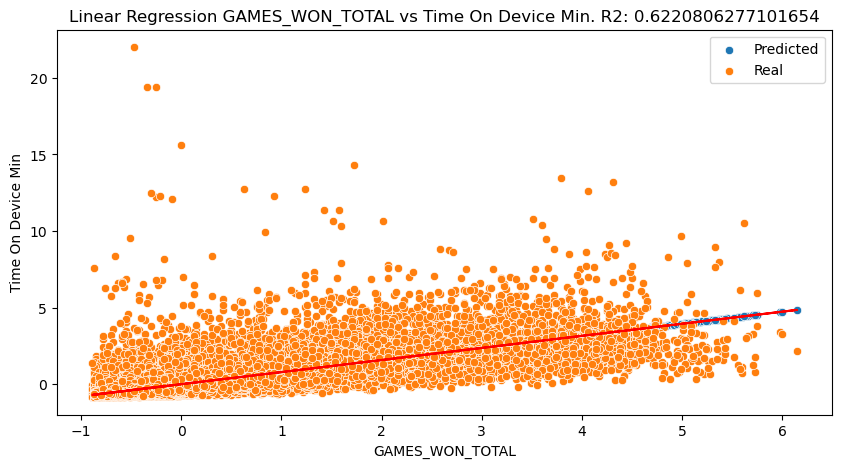

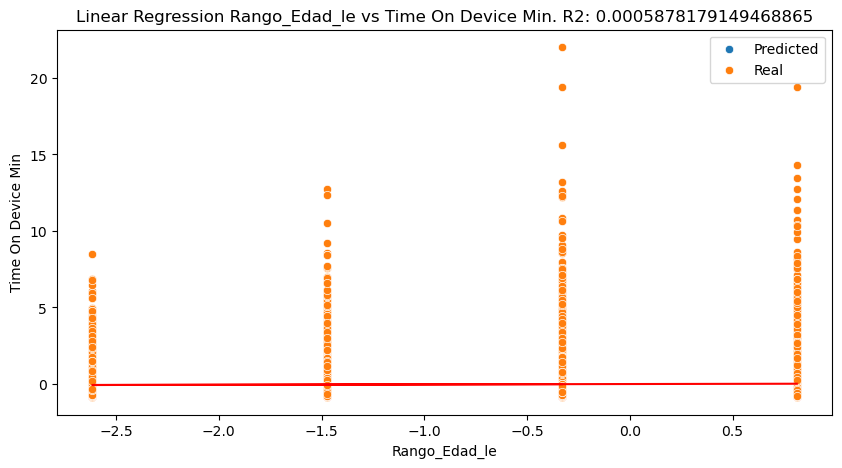

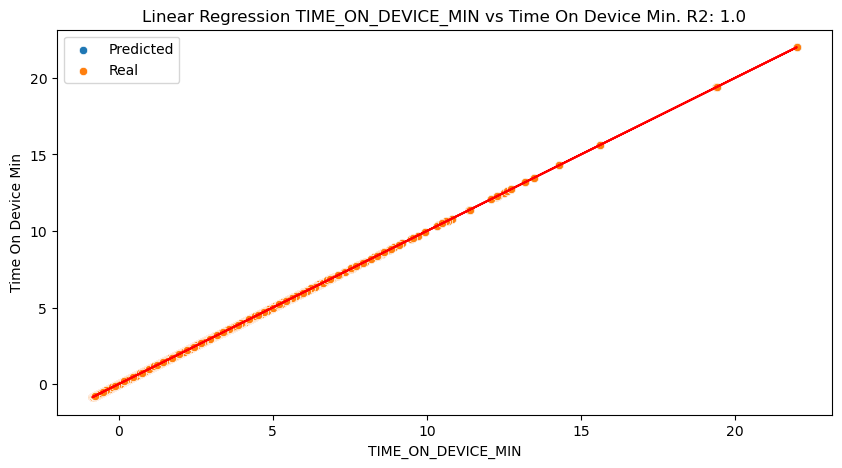

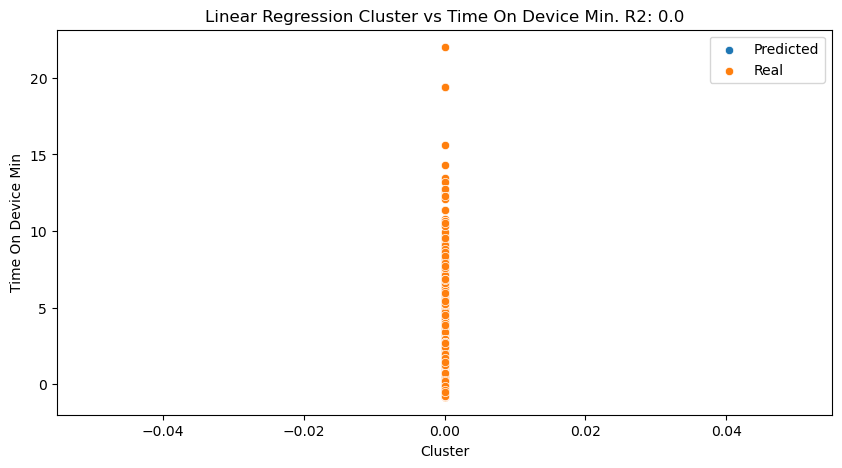

In [33]:
std_scaler_time = StandardScaler()
y = df_cluster3[['TIME_ON_DEVICE_MIN']]
y_scaled = std_scaler_time.fit_transform(y)
for column in df_cluster3.columns:
    std_scaler = StandardScaler()
    X = df_cluster3[[column]]
    X_scaled = std_scaler.fit_transform(X)
    
    lr = LinearRegression()

    lr.fit(X_scaled, y_scaled)
    y_hat = lr.predict(X_scaled)

    r2_value = r2_score(y_scaled, y_hat)
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=X_scaled.ravel(), y=y_hat.ravel(), label='Predicted')
    sns.scatterplot(x=X_scaled.ravel(), y=y_scaled.ravel(), label='Real')
    plt.plot(X_scaled.ravel(), y_hat.ravel(), color="red")


    plt.title(f"Linear Regression {column} vs Time On Device Min. R2: {r2_value}")
    plt.xlabel(column)
    plt.ylabel("Time On Device Min")
    print(f"{column} vs Time On Device Min. R2 {r2_value}")

### Original data

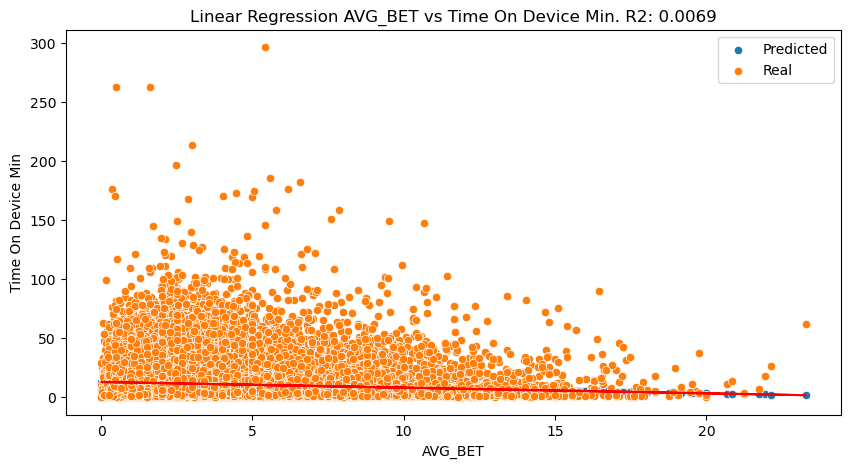

AVG_BET vs Time On Device Min. R2 0.0069


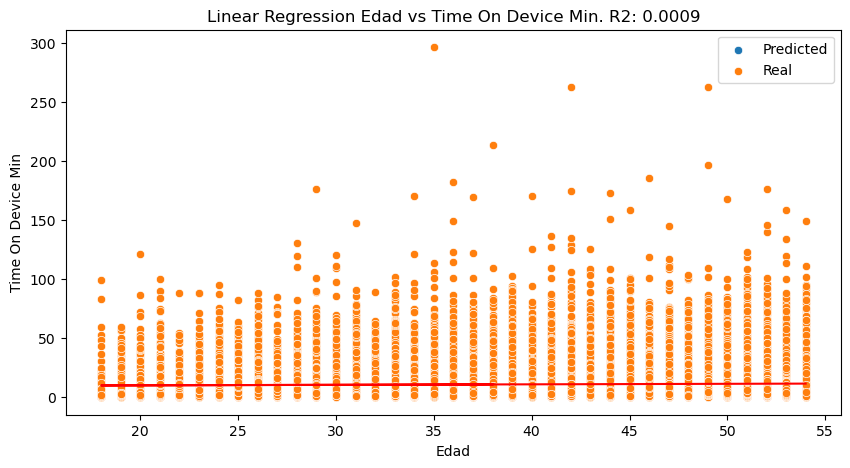

Edad vs Time On Device Min. R2 0.0009


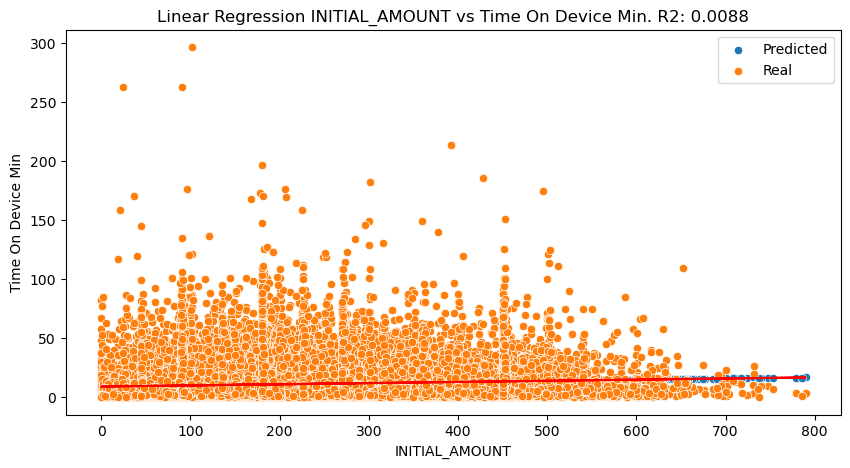

INITIAL_AMOUNT vs Time On Device Min. R2 0.0088


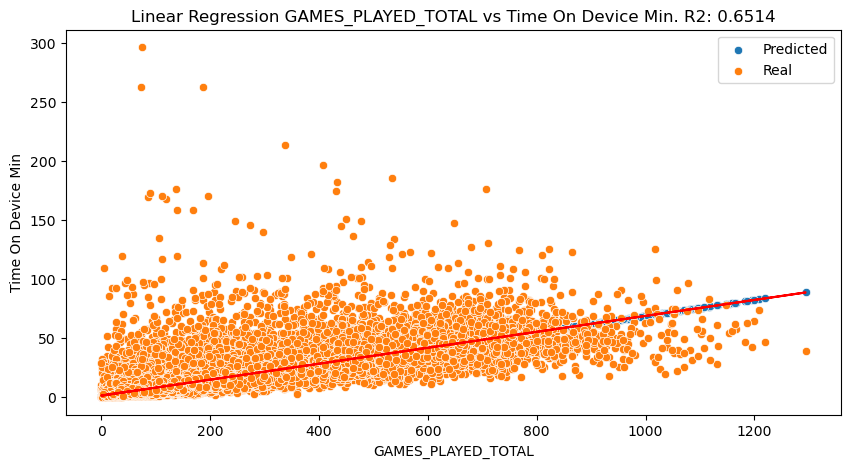

GAMES_PLAYED_TOTAL vs Time On Device Min. R2 0.6514


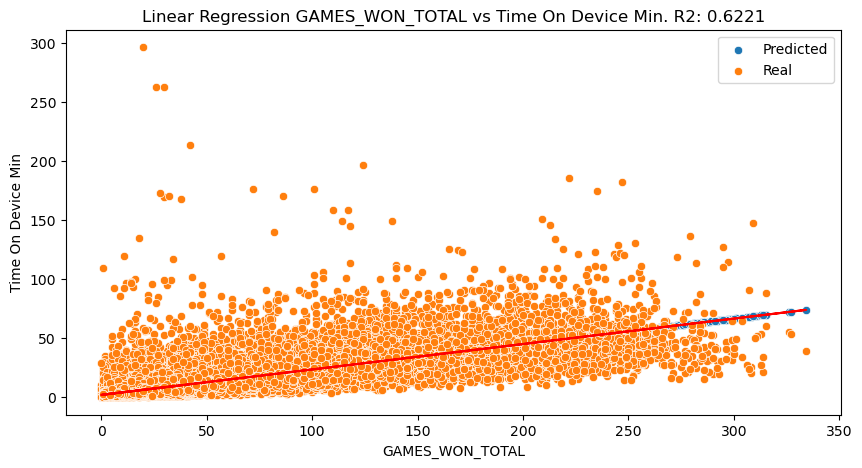

GAMES_WON_TOTAL vs Time On Device Min. R2 0.6221


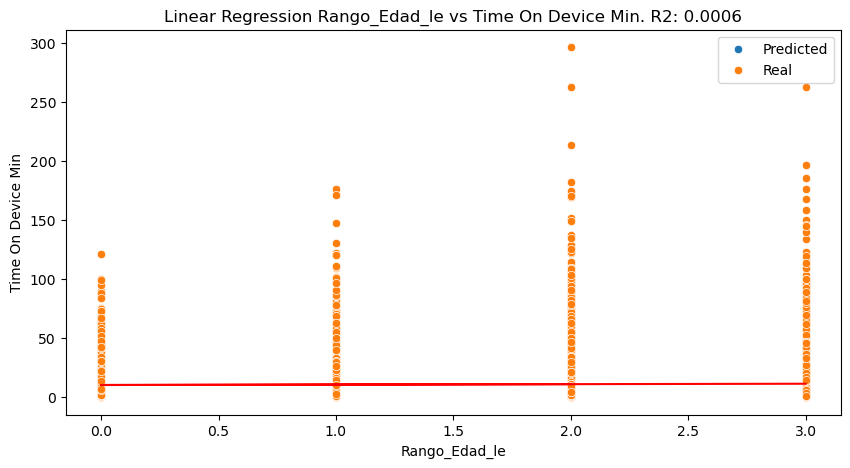

Rango_Edad_le vs Time On Device Min. R2 0.0006


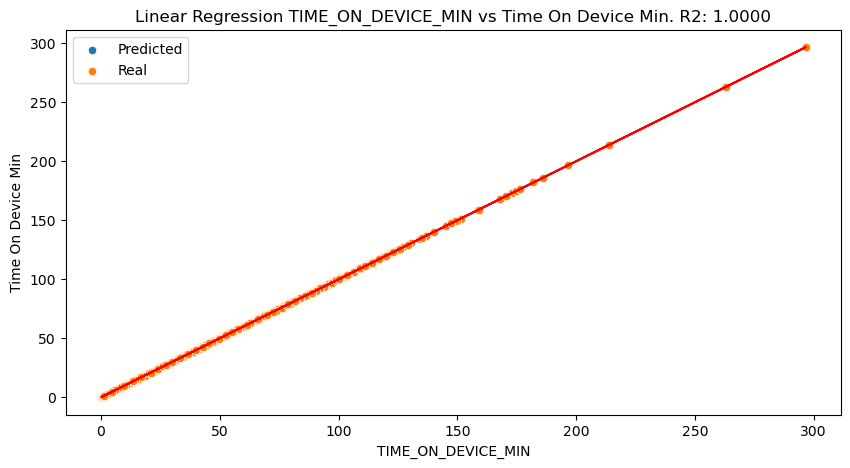

TIME_ON_DEVICE_MIN vs Time On Device Min. R2 1.0000


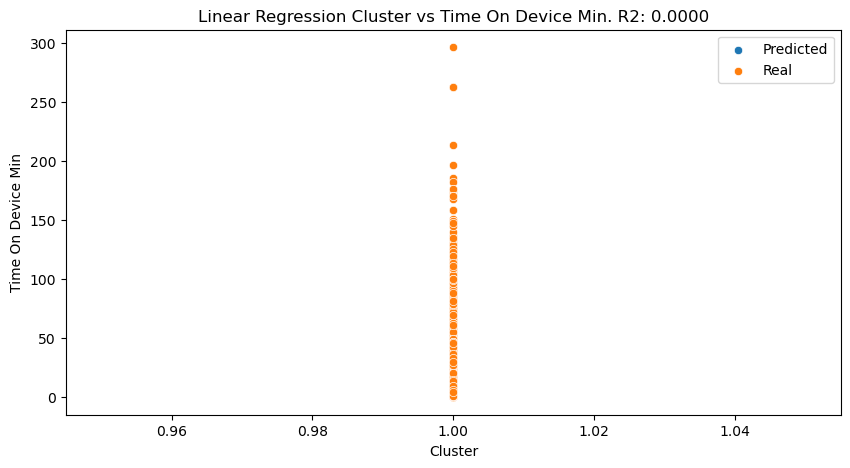

Cluster vs Time On Device Min. R2 0.0000


In [34]:
y = df_cluster3['TIME_ON_DEVICE_MIN'].values  # ahora es NumPy array

for column in df_cluster3.columns:
    X = df_cluster3[[column]].values  # también NumPy array
    
    lr = LinearRegression()
    lr.fit(X, y)
    y_hat = lr.predict(X)

    r2_value = r2_score(y, y_hat)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=X.ravel(), y=y_hat.ravel(), label='Predicted')
    sns.scatterplot(x=X.ravel(), y=y.ravel(), label='Real')
    plt.plot(X.ravel(), y_hat.ravel(), color="red")

    plt.title(f"Linear Regression {column} vs Time On Device Min. R2: {r2_value:.4f}")
    plt.xlabel(column)
    plt.ylabel("Time On Device Min")
    plt.legend()
    plt.show()

    print(f"{column} vs Time On Device Min. R2 {r2_value:.4f}")

## Games Played Regression

### Standard Scaler + Poly

AVG_BET vs Games Played. R2 0.020478812481388387
Edad vs Games Played. R2 0.004585767272965113
INITIAL_AMOUNT vs Games Played. R2 0.025512163336305016
GAMES_PLAYED_TOTAL vs Games Played. R2 1.0
GAMES_WON_TOTAL vs Games Played. R2 0.8066424580291324
Rango_Edad_le vs Games Played. R2 0.0035634262459754984
TIME_ON_DEVICE_MIN vs Games Played. R2 0.7344638018067453
Cluster vs Games Played. R2 0.0


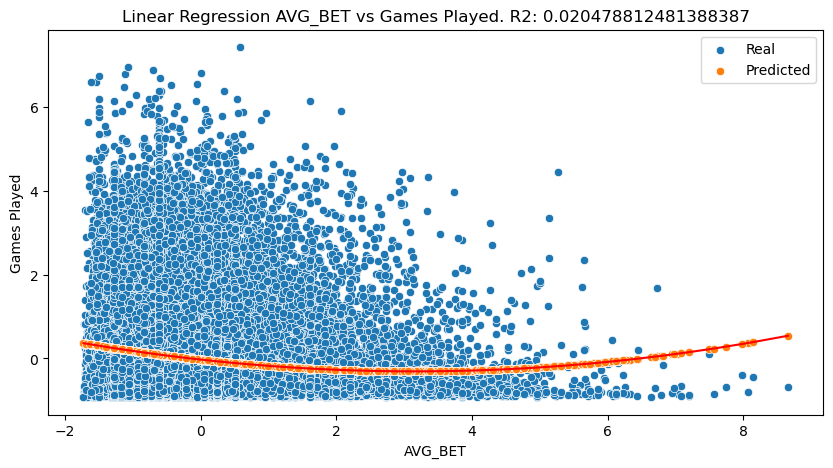

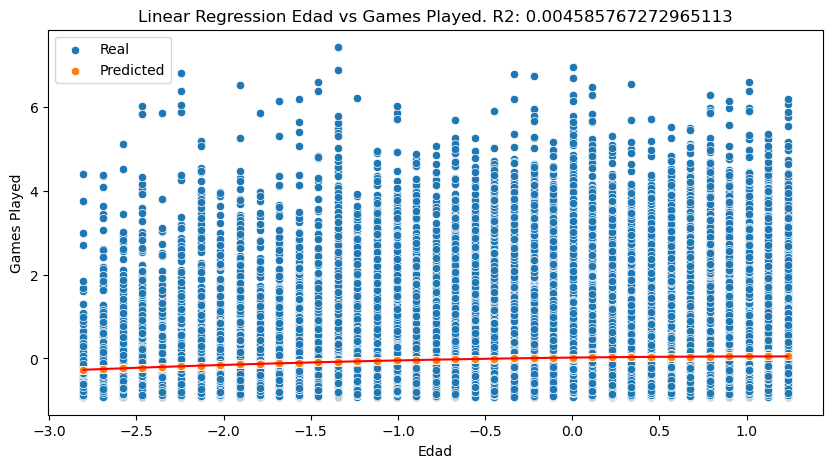

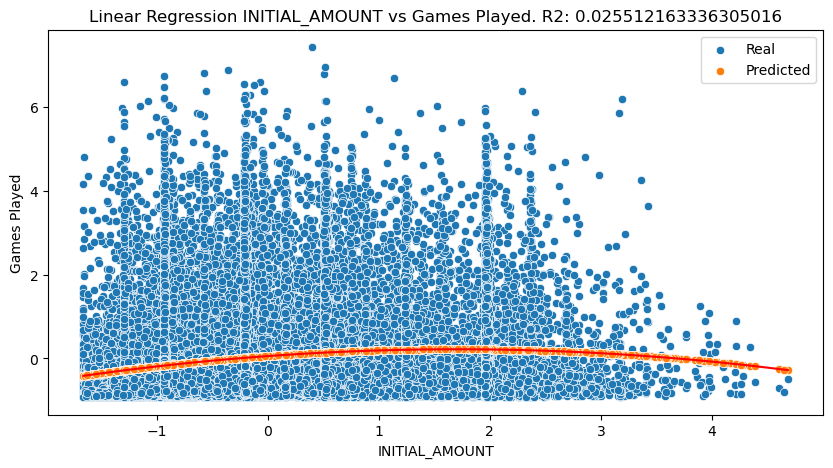

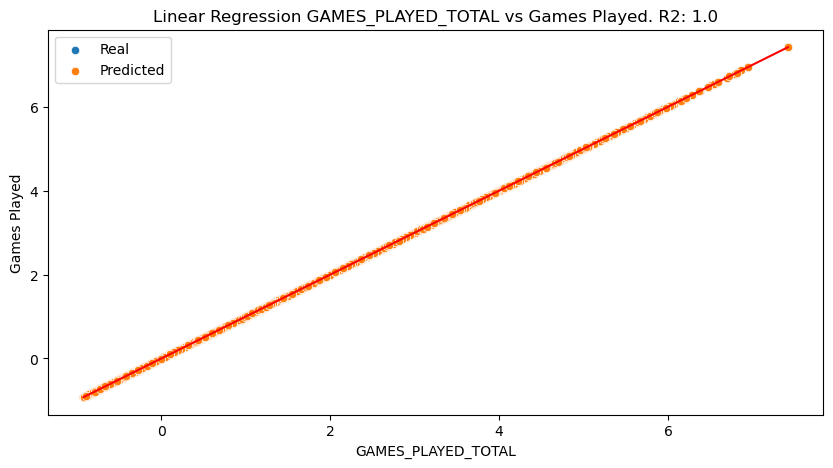

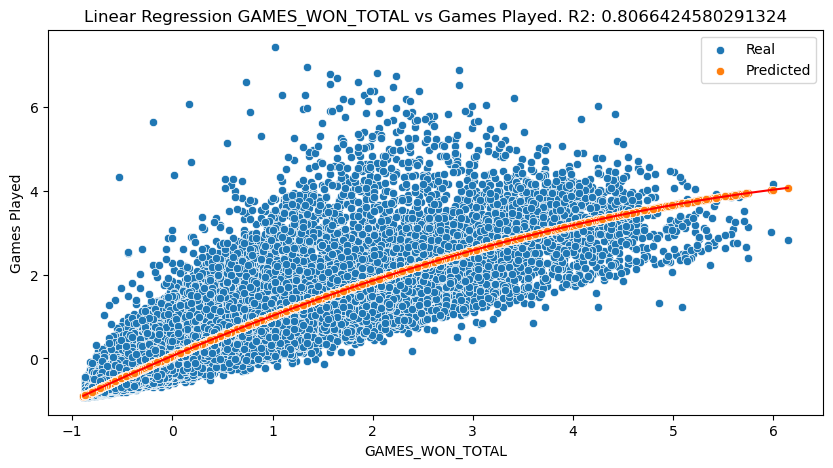

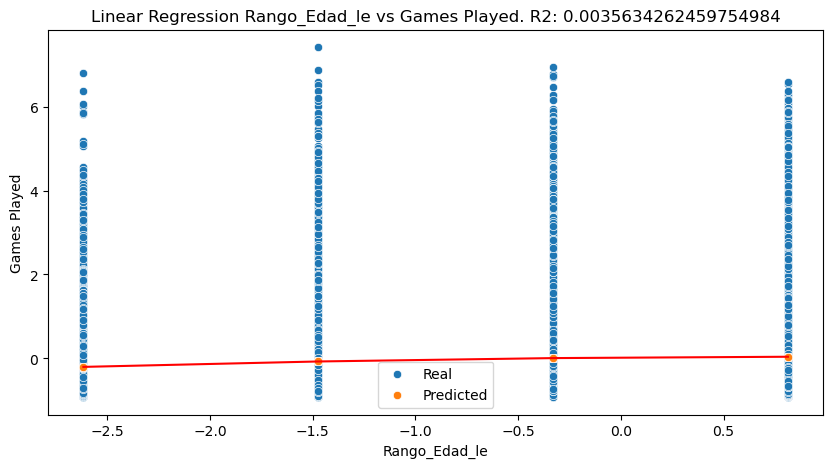

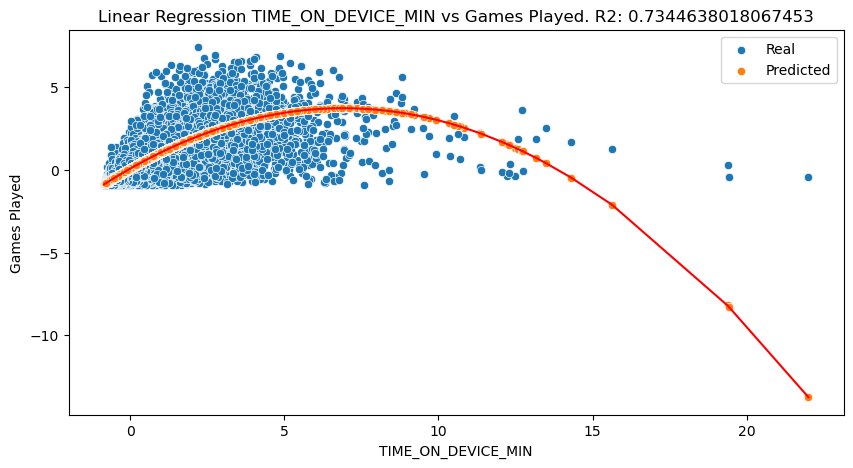

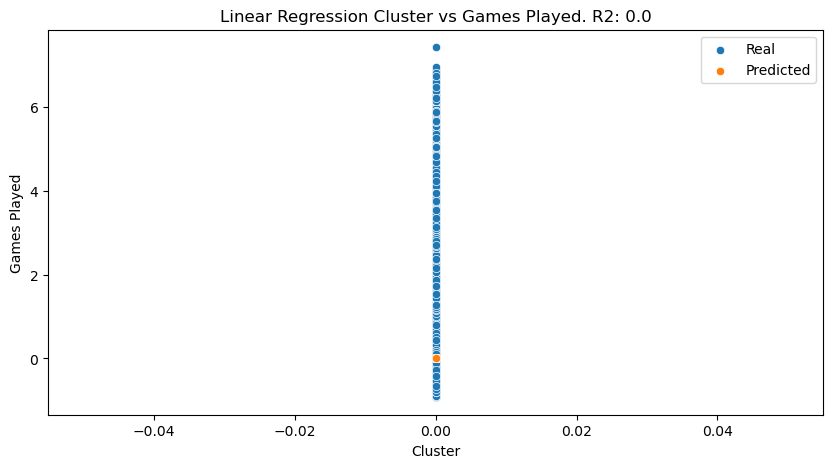

In [35]:
std_scaler_time = StandardScaler()
y = df_cluster3[['GAMES_PLAYED_TOTAL']]
y_scaled = std_scaler_time.fit_transform(y)
for column in df_cluster3.columns:
    std_scaler = StandardScaler()
    X = df_cluster3[[column]]
    X_scaled = std_scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_scaled)
    lr = LinearRegression()

    lr.fit(X_poly, y_scaled)
    y_hat = lr.predict(X_poly)

    r2_value = r2_score(y_scaled, y_hat)
    plt.figure(figsize=(10,5))
    # Para graficar, usamos el X original (una sola variable)
    sns.scatterplot(x=X_scaled.ravel(), y=y_scaled.ravel(), label='Real')
    sns.scatterplot(x=X_scaled.ravel(), y=y_hat.ravel(), label='Predicted')

    # Ordenamos X para graficar una curva suave
    sorted_idx = np.argsort(X_scaled.ravel())
    plt.plot(X_scaled.ravel()[sorted_idx], y_hat.ravel()[sorted_idx], color="red")



    plt.title(f"Linear Regression {column} vs Games Played. R2: {r2_value}")
    plt.xlabel(column)
    plt.ylabel("Games Played")
    print(f"{column} vs Games Played. R2 {r2_value}")

### Standard Scaler

AVG_BET vs Games Played Total. R2 0.01752179733967607
Edad vs Games Played Total. R2 0.004104943298842589
INITIAL_AMOUNT vs Games Played Total. R2 0.02089905205554965
GAMES_PLAYED_TOTAL vs Games Played Total. R2 1.0
GAMES_WON_TOTAL vs Games Played Total. R2 0.7981568648130927
Rango_Edad_le vs Games Played Total. R2 0.003184943342761204
TIME_ON_DEVICE_MIN vs Games Played Total. R2 0.6513857144874111
Cluster vs Games Played Total. R2 0.0


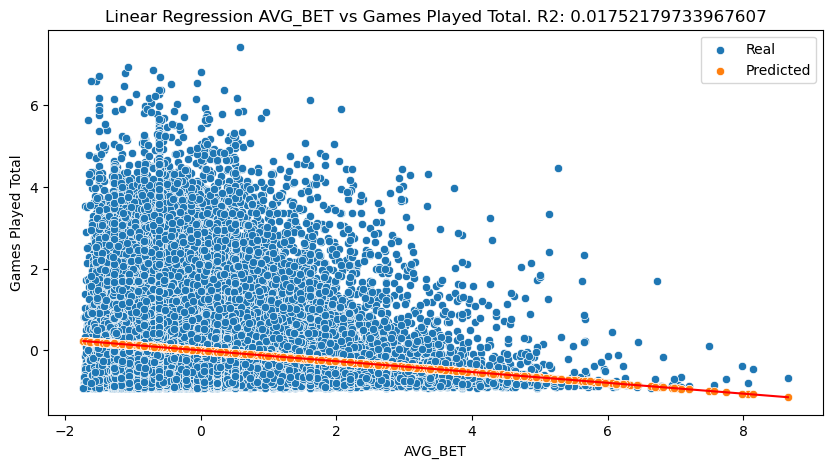

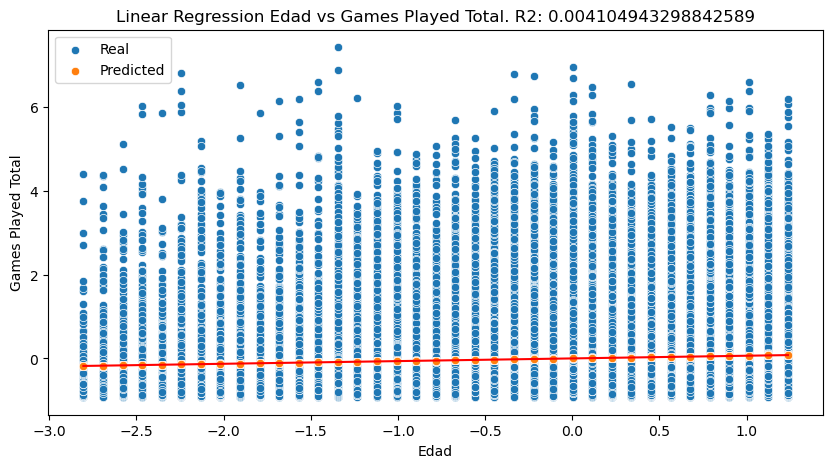

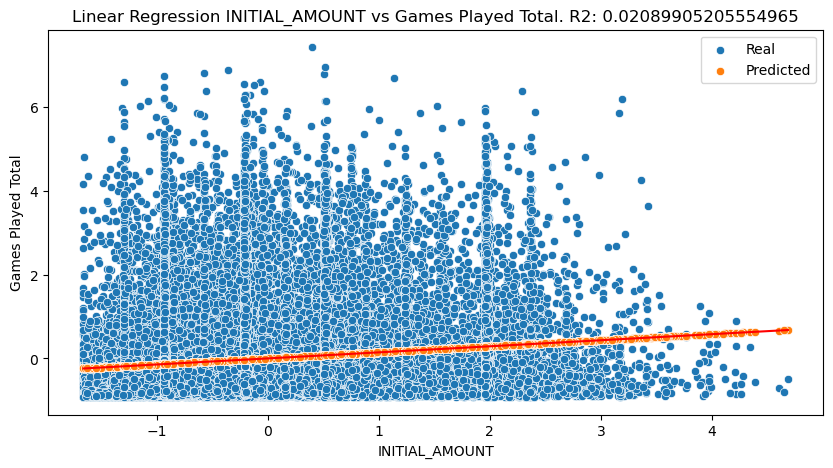

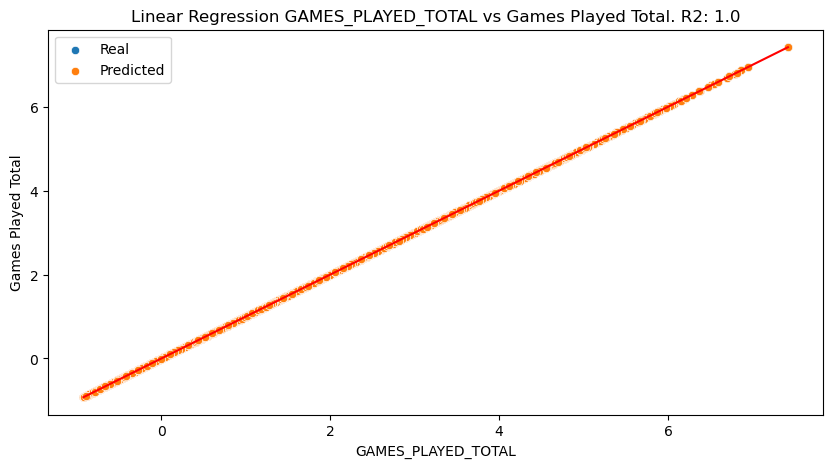

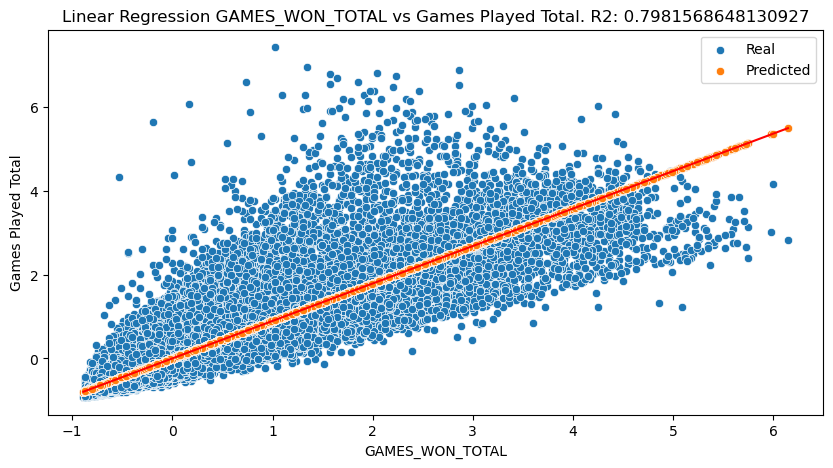

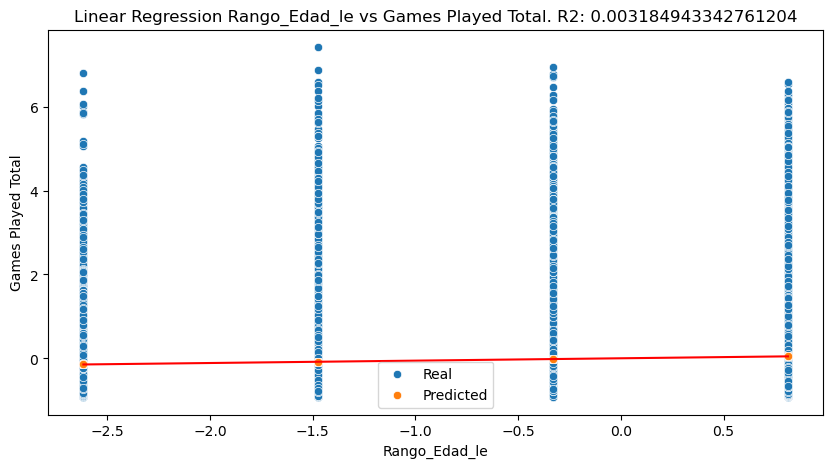

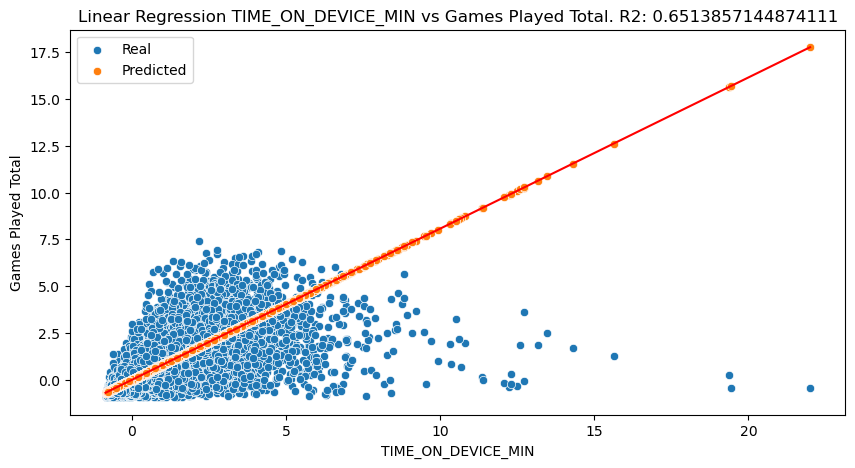

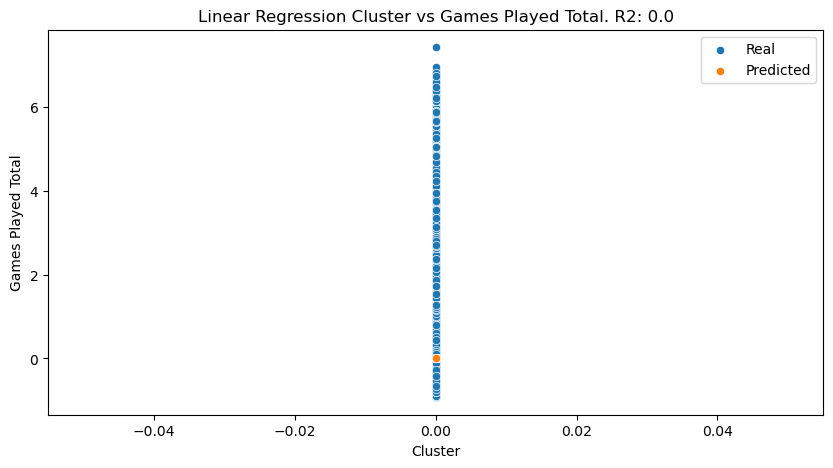

In [36]:
std_scaler_time = StandardScaler()
y = df_cluster3[['GAMES_PLAYED_TOTAL']]
y_scaled = std_scaler_time.fit_transform(y)
for column in df_cluster3.columns:
    std_scaler = StandardScaler()
    X = df_cluster3[[column]]
    X_scaled = std_scaler.fit_transform(X)
    lr = LinearRegression()

    lr.fit(X_scaled, y_scaled)
    y_hat = lr.predict(X_scaled)

    r2_value = r2_score(y_scaled, y_hat)
    plt.figure(figsize=(10,5))
    # Para graficar, usamos el X original (una sola variable)
    sns.scatterplot(x=X_scaled.ravel(), y=y_scaled.ravel(), label='Real')
    sns.scatterplot(x=X_scaled.ravel(), y=y_hat.ravel(), label='Predicted')

    # Ordenamos X para graficar una curva suave
    sorted_idx = np.argsort(X_scaled.ravel())
    plt.plot(X_scaled.ravel()[sorted_idx], y_hat.ravel()[sorted_idx], color="red")



    plt.title(f"Linear Regression {column} vs Games Played Total. R2: {r2_value}")
    plt.xlabel(column)
    plt.ylabel("Games Played Total")
    print(f"{column} vs Games Played Total. R2 {r2_value}")

### Poly

AVG_BET vs Games Played Total. R2 0.020478812481388387
Edad vs Games Played Total. R2 0.004585767272965113
INITIAL_AMOUNT vs Games Played Total. R2 0.025512163336305238
GAMES_PLAYED_TOTAL vs Games Played Total. R2 1.0
GAMES_WON_TOTAL vs Games Played Total. R2 0.8066424580291324
Rango_Edad_le vs Games Played Total. R2 0.0035634262459754984
TIME_ON_DEVICE_MIN vs Games Played Total. R2 0.7344638018067453
Cluster vs Games Played Total. R2 0.0


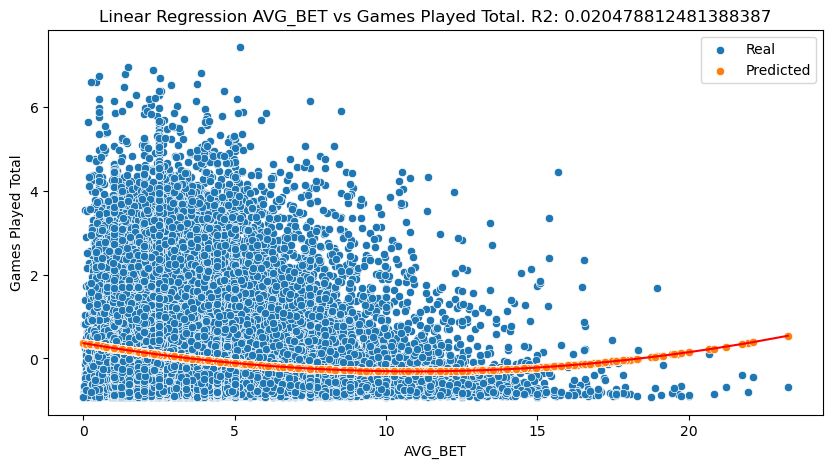

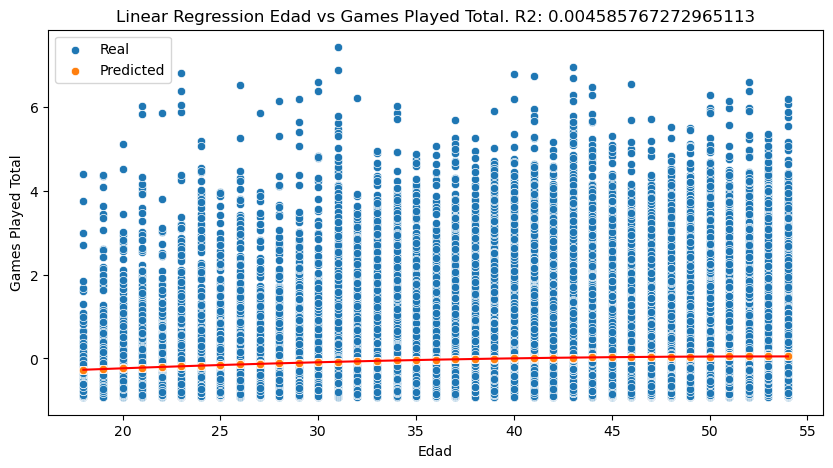

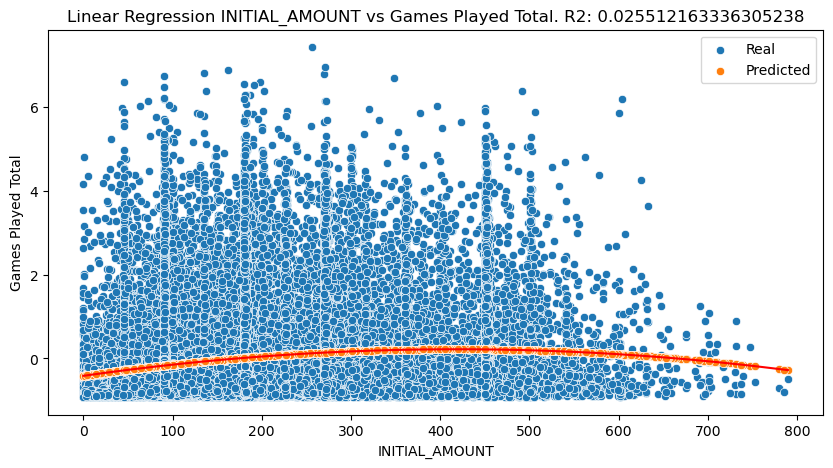

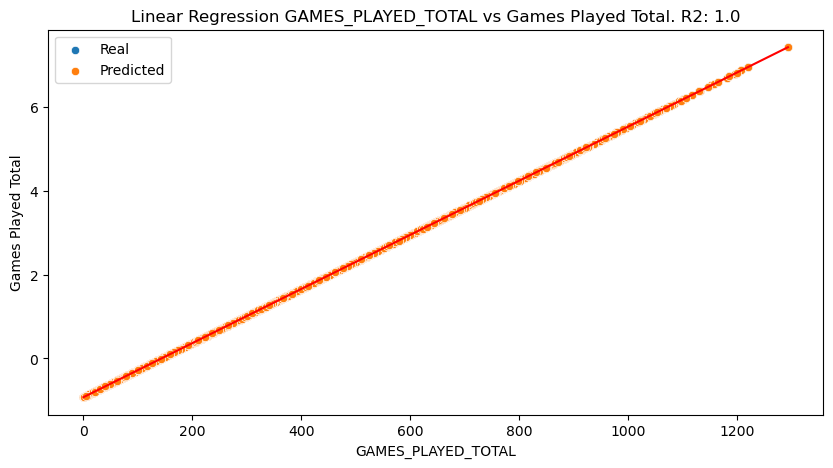

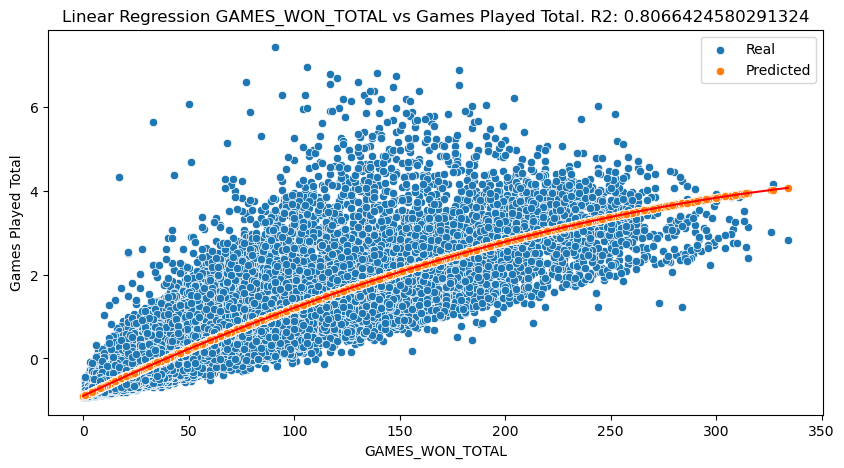

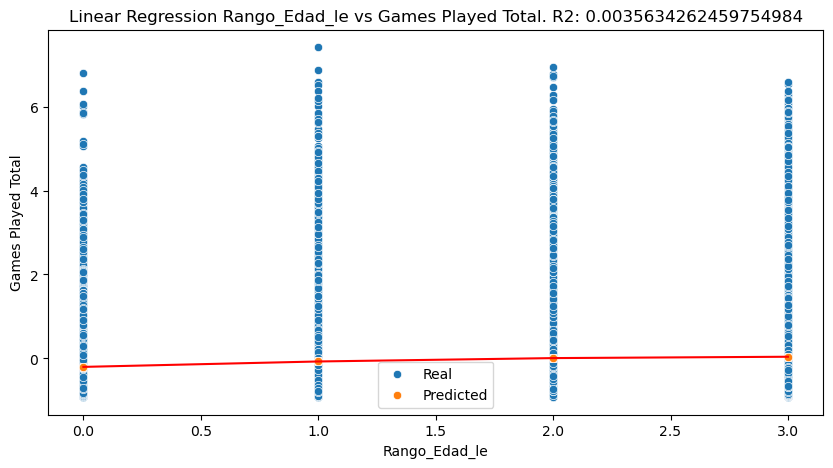

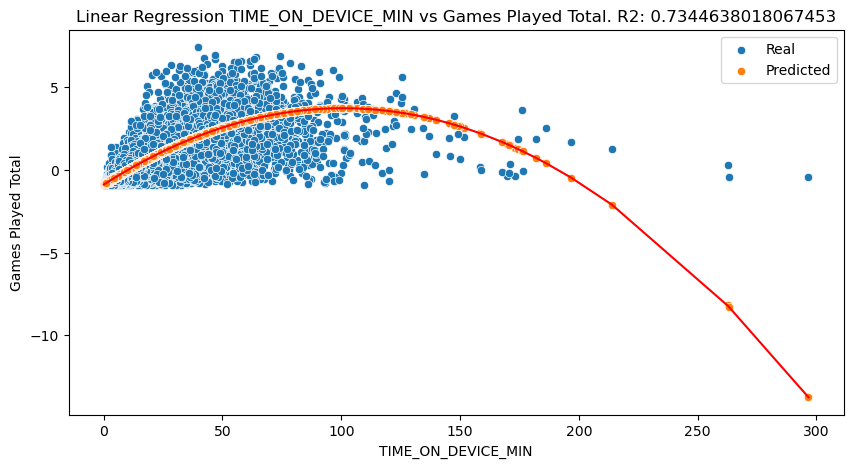

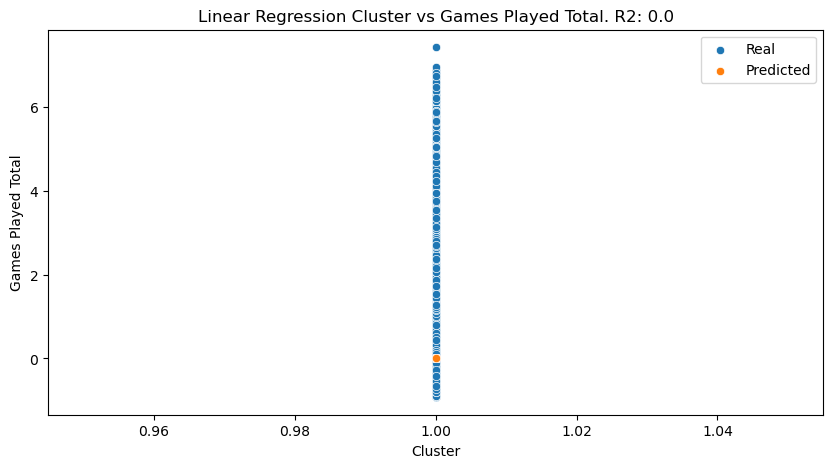

In [37]:

y = df_cluster3[['GAMES_PLAYED_TOTAL']].values
for column in df_cluster3.columns:
    std_scaler = StandardScaler()
    X = df_cluster3[[column]].values
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()

    lr.fit(X_poly, y_scaled)
    y_hat = lr.predict(X_poly)

    r2_value = r2_score(y_scaled, y_hat)
    plt.figure(figsize=(10,5))
    # Para graficar, usamos el X original (una sola variable)
    sns.scatterplot(x=X.ravel(), y=y_scaled.ravel(), label='Real')
    sns.scatterplot(x=X.ravel(), y=y_hat.ravel(), label='Predicted')

    # Ordenamos X para graficar una curva suave
    sorted_idx = np.argsort(X.ravel())
    plt.plot(X.ravel()[sorted_idx], y_hat.ravel()[sorted_idx], color="red")



    plt.title(f"Linear Regression {column} vs Games Played Total. R2: {r2_value}")
    plt.xlabel(column)
    plt.ylabel("Games Played Total")
    print(f"{column} vs Games Played Total. R2 {r2_value}")

### Normal data

AVG_BET vs Games Played Total. R2 0.017521797339676404
Edad vs Games Played Total. R2 0.004104943298842589
INITIAL_AMOUNT vs Games Played Total. R2 0.020899052055549983
GAMES_PLAYED_TOTAL vs Games Played Total. R2 1.0
GAMES_WON_TOTAL vs Games Played Total. R2 0.7981568648130927
Rango_Edad_le vs Games Played Total. R2 0.003184943342761426
TIME_ON_DEVICE_MIN vs Games Played Total. R2 0.6513857144874112
Cluster vs Games Played Total. R2 0.0


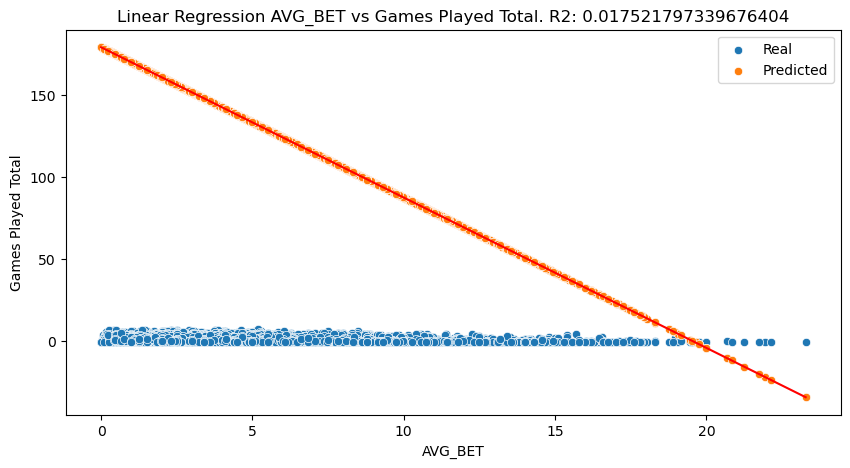

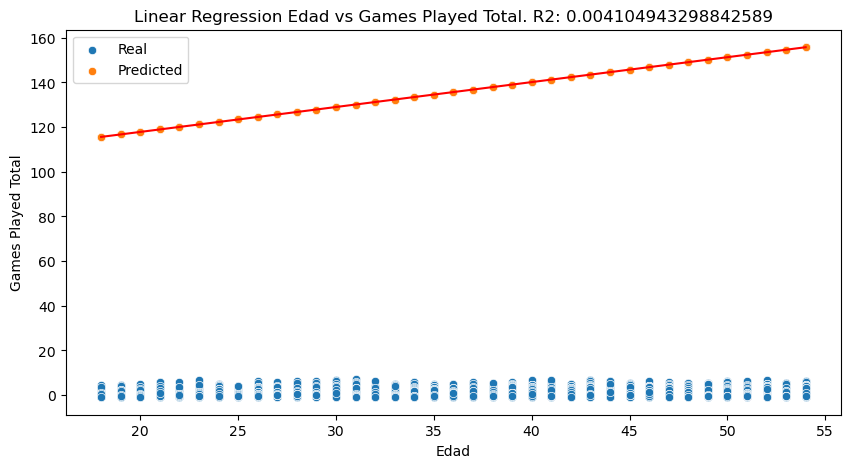

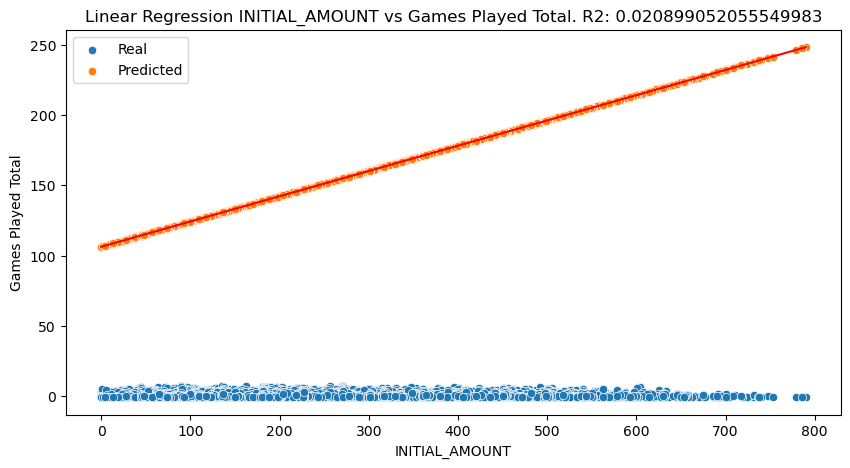

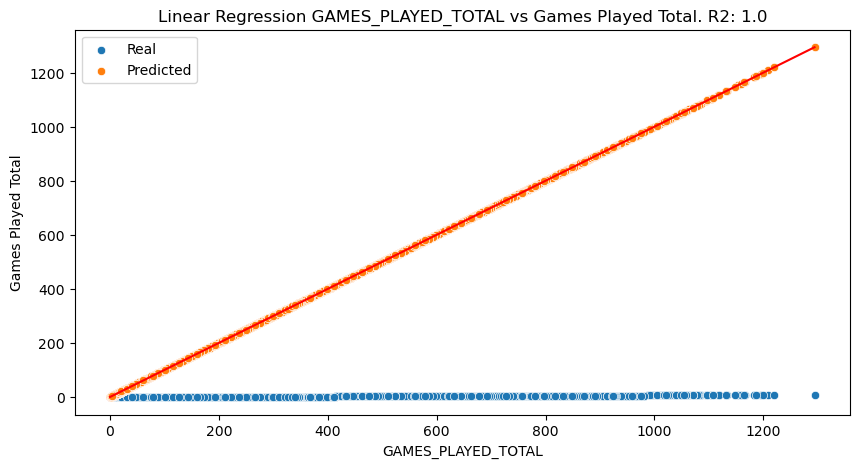

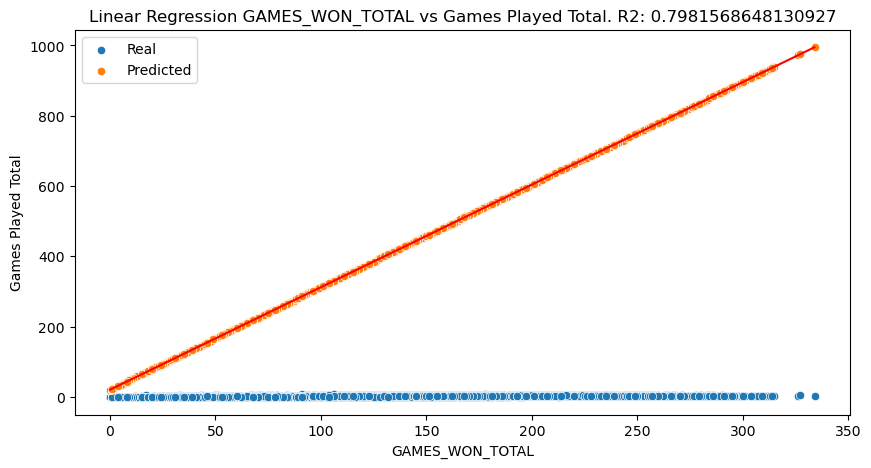

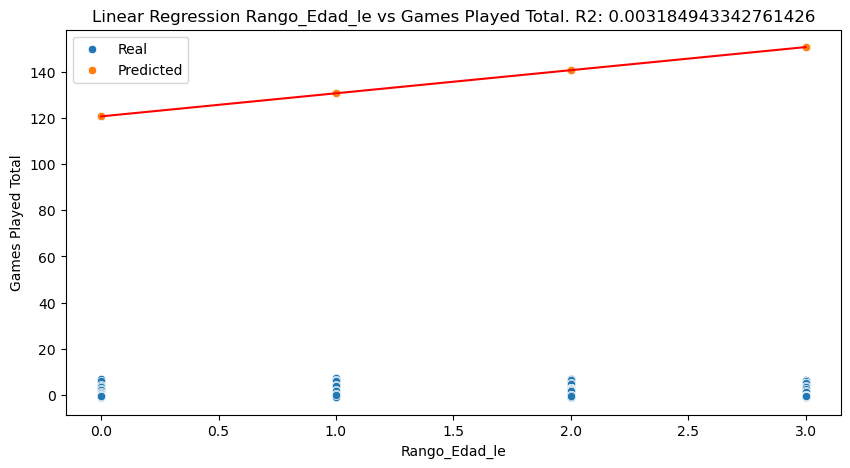

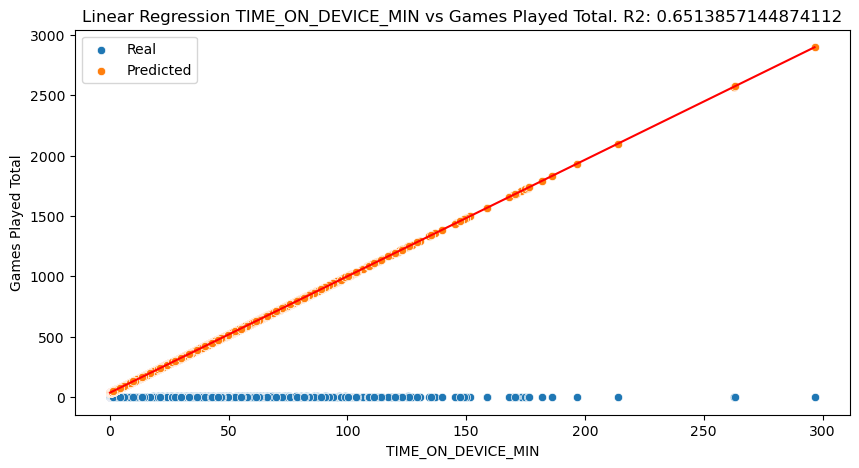

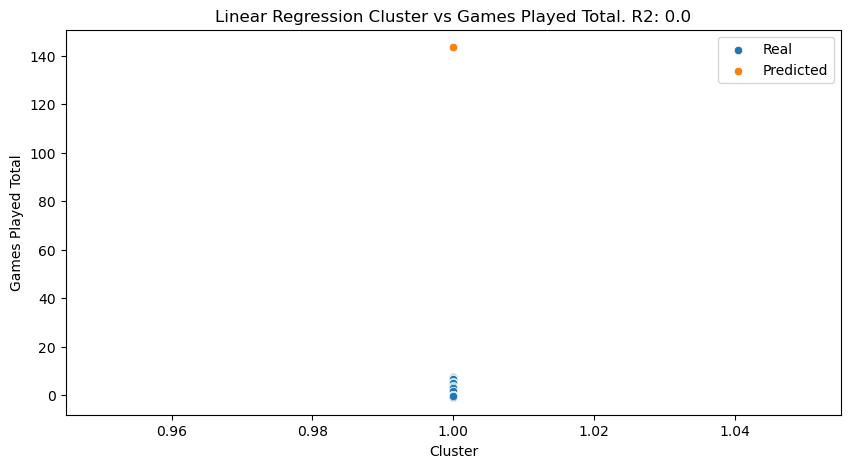

In [38]:

y = df_cluster3['GAMES_PLAYED_TOTAL'].values
for column in df_cluster3.columns:
    X = df_cluster3[[column]].values
    lr = LinearRegression()

    lr.fit(X, y)
    y_hat = lr.predict(X)

    r2_value = r2_score(y, y_hat)
    plt.figure(figsize=(10,5))
    # Para graficar, usamos el X original (una sola variable)
    sns.scatterplot(x=X.ravel(), y=y_scaled.ravel(), label='Real')
    sns.scatterplot(x=X.ravel(), y=y_hat.ravel(), label='Predicted')

    # Ordenamos X para graficar una curva suave
    sorted_idx = np.argsort(X.ravel())
    plt.plot(X.ravel()[sorted_idx], y_hat.ravel()[sorted_idx], color="red")



    plt.title(f"Linear Regression {column} vs Games Played Total. R2: {r2_value}")
    plt.xlabel(column)
    plt.ylabel("Games Played Total")
    print(f"{column} vs Games Played Total. R2 {r2_value}")